In [248]:
%reset -f
import torch
from fastai.vision.all import *
torch.cuda.get_device_name(0)   
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Lets download pictures of dogs and cats from a source provided by FastAI.

This will be stored in a variable `path`, which will contain the absolute paths to these images

In [249]:
path = untar_data(URLs.PETS)/'images'

We can print these paths with `ls()`, a method provided by fastAI similar to that seen in the OS.

The result is a fastAI list, `L`.

In [250]:
path.ls() 

(#7390) [Path('C:/Users/logan/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),Path('C:/Users/logan/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),Path('C:/Users/logan/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),Path('C:/Users/logan/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),Path('C:/Users/logan/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg'),Path('C:/Users/logan/.fastai/data/oxford-iiit-pet/images/Abyssinian_103.jpg'),Path('C:/Users/logan/.fastai/data/oxford-iiit-pet/images/Abyssinian_104.jpg'),Path('C:/Users/logan/.fastai/data/oxford-iiit-pet/images/Abyssinian_105.jpg'),Path('C:/Users/logan/.fastai/data/oxford-iiit-pet/images/Abyssinian_106.jpg'),Path('C:/Users/logan/.fastai/data/oxford-iiit-pet/images/Abyssinian_107.jpg')...]

In this dataset, all the images are in a single folder `images`, but we can distinguish between images of dogs and cats, as the filenames of cat images are capitalised.

Thus we can define:

In [251]:
 def is_cat(x): return x[0].isupper()

Next we need to declare a validation set and a training set.

Let's declare the validation set at 20%.

We'll use a seed `42` for reproducibility.

In [252]:
dogsAndCats = (path).ls().sorted()

validation_set_percentage = 0.20
num_of_validation = int(len(dogsAndCats) * validation_set_percentage)
random.seed(42)
random.shuffle(dogsAndCats)

validation_set = dogsAndCats[:num_of_validation]
training_set = dogsAndCats[num_of_validation:]

len(training_set),len(validation_set)

(5912, 1478)

Lets display an image

C:\Users\logan\.fastai\data\oxford-iiit-pet\images\Abyssinian_212.jpg


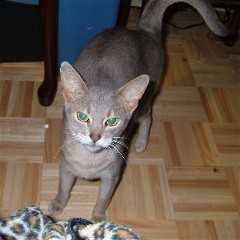

In [253]:
image1 = training_set[0]
print(image1) # Display image directory

cat1 = Image.open(image1)
cat1

Lets open these images and store them in a tensor.

We will need to resize each image so they are uniform, we could pick any size,but we will go with 192x192

For further conformity, we will also need to ensure all our images are `rgb`, so we can use a convienent function `convert` for that.

If you get an error here - There is a problem with the dataset including `.mat` images. You can remove these.

In [254]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor()
])

# Load and convert all images to RGB mode
training_tensor = [transform(Image.open(o).convert('RGB')) for o in training_set]
validation_tensor = [transform(Image.open(o).convert('RGB')) for o in validation_set]

len(training_tensor),len(validation_tensor)

(5912, 1478)

Lets now quickly check our images are doing alright:

<Axes: >

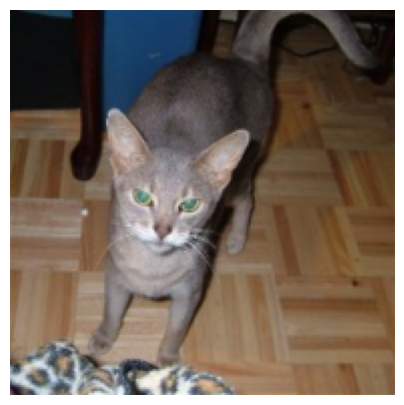

In [255]:
show_image(training_tensor[0])

We need to convert these images into a single, Four-dimensional tensor.

PyTorch can do this for us with `stack`, but we need to cast the image pixel values to floats, as currently they are integers.

A pixel can be between the values 0 to 255, but PyTorch is expecting numbers between 0 and 1.

We'll just divide each pixel by 255 to get a nice number between 0 and 1.

In [256]:
stacked_images = torch.stack(training_tensor).float() / 255

Now we have all our images stacked into a single, 4D tensor.

We can see the shape of this tensor with the following:

In [257]:
 stacked_images.shape

torch.Size([5912, 3, 192, 192])

5912 images across 3 channels (r,g,b) with size 192x192

Lets make this into our x-axis and convert this tensor into a 2D tensor.


In [258]:
train_x = stacked_images.view(len(stacked_images),-1)
train_x.shape

torch.Size([5912, 110592])

As a result we have a 2D vector of 5912 images.

Each image is 192x192 pixels, across 3 channels, thus each image is $(192x192)3$ pixels.

Thus the shape is [7390,110592]

Next we need to define the Y labels:

Earlier we defined a function `is_cat` which determines whether an image is a cat by looking at the filename.
- If it is capitalised, it is a cat.
- If it is not capitalised, it is a dog.

Thus was can define our labels train_y based on this logic.


In [259]:
labels = []

for file_path in training_set:
    filename = file_path.name
    label = 0 if is_cat(filename[0]) else 1 # is_cat was defined earlier
    labels.append(label)

train_y = torch.tensor(labels).unsqueeze(1)
train_y.shape

torch.Size([5912, 1])

Our result is a 2D tensor, length 7390, with each item being just a single digit.

We can now zip these together into a single dataset.    

In [260]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([110592]), tensor([0]))

We can take the first tuple from our dataset, and unpack it into `x` and `y`.

We can see the shape of `x` and see a tensor of 110592 numbers.

We can display the value of `y` to conclude whether it is a cat, in this case, the value is 0, and thus we can conclude it is a cat.

We now have a nice, labelled dataset to use.

Lets repeat this for our validation set.

In [309]:
stacked_validation_images = torch.stack(validation_tensor).float() / 255
valid_x = stacked_validation_images.view(len(stacked_validation_images),-1)

valid_labels = []

for file_path in validation_set:
    filename = file_path.name
    label = 0 if is_cat(filename[0]) else 1 
    valid_labels.append(label)

valid_y = torch.tensor(valid_labels).unsqueeze(1)

valid_dset = list(zip(valid_x,valid_y))
x,y = valid_dset[0]
x.shape,y

(torch.Size([110592]), tensor([1]))

We now need to make weights, which our model will improve.

There are many methods of initialising weights but the easiest is to just to assign them randomly.

In [262]:
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_() 

This function initialises parameters of a set size:

- Size is the shape or size of the tensor we want to initialise.
- `std` is optional, it sets the standard deviation of values in the initialised tensor.
- `torch.randn(size)` generates a tensor with random values sampled from a normal distribution with mean of 0, and standard deviation of 1.
- `.requires_grad_()` is used to indicate these parameters will require gradient calculation during training.

We'll declare weights of size 198*198 - the size of our images, multiplied by 3 for each dimension.

In [263]:
weights = init_params((192*192)*3,1)

We now need some way to make a prediction with our model,

We could do $weights*pixel$ for each pixel in the image, but this leaves us with an issue:
- If the pixel is 0, we are left with a value equal to 0.
- The intercept of this function is 0.

We can adapt a formula similar to that of a line, $y=mx+b$  and define it as $y=w*x+b$
- y is the prediction output
- w represents weights
- x represents the input (pixels)
- b is a bias term to avoid being stuck passing through the origin.

We can define b as a random number

In [264]:
bias = init_params(1)

Lets make a prediction for an image now, using our $y=wx+b$

In [265]:
(train_x[0]*weights.T).sum() + bias

tensor([0.8155], grad_fn=<AddBackward0>)

- train+x[0] is the pixel values for the first image
- in `weights.t`, the `t` means transpose, it is taking the `transpose` of the weights vector
  - weights is a column vector, transposing it makes it a row vector
  - We're just making sure the dimensions of `train_x[0]` and `weights` line up formultiplication.
-  `(train_x[0]*weights.T)` performs the element-wise multiplicaiton between the pixel values for the image and weights. Since they are both the same size, we end up with a vector containing the products of all corresponding elements in both vectors, .sum() then just sums them up.


We're essentially getting the dot product between the first image and the weights, and then add the bias term.

Now we need to do this for each one of our images to train over the whole set.

Python for loops are slow though.

We could instead turn to matrix-multiplication to help us out here.

In python, we use the @ operator for matrix multiplication.

Lets define our training as a function.

In [266]:
def linear1(xb):
    return xb@weights+bias

Lets run it against images, and see if we get the same results.

In [267]:
preds = linear1(train_x[0])
preds

tensor([0.8155, 1.0090, 1.0767,  ..., 0.7379, 1.1263, 0.8250], grad_fn=<AddBackward0>)

The first value is the same value as earlier, so we have converted $y=wx+b$ to $y=w \cdot x + b$ , very similar, but this time we are conducting matrix multiplication on our two matrices, w (weights( and x (pixels)

Lets throw all our values into this function, and store the resulting predictions.

In [268]:
preds = linear1(train_x)
preds

tensor([0.8155, 1.0090, 1.0767,  ..., 0.7379, 1.1263, 0.8250], grad_fn=<AddBackward0>)

- We take in our `train_x` dataset
- xb@weights performs matrix multiplication between the input data `xb` and the weights `weights`
- We then add our bias term

We can pass in the entire dataset `train_x`, to get predictions for each value in the set.

We next need to define a function that can find the accuracy of our model.

Recall that we defined:
- If an image is a cat, it has the label 0
- If an image is a dog, it has the label 1

We can thus define:

In [269]:
corrects = (preds>0.0).float() == train_y
corrects  

tensor([[False, False, False,  ..., False, False, False],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [False, False, False,  ..., False, False, False]])

If the prediction is over 0, we presume the model guesses this is a dog, turn this into `1`, and check it against our label

Otherwise, we presume the model guesses this is a cat, turn this into a `0` and check it against the label.

It's important to use broadcasting here and avoid loops.

The final result is a boolean tensor, true if the prediction matches the label, false otherwise.

## Example
Say the value being checked by preds is 18.3804 and the equivalent train_y is 0

We then do (preds > 0.000), or in other words 18.3804 > 0.00, which gives true

We then do (preds>0.0).float() which is giving 1, as we're basically doing (true).float()

And this fails the comparison `1 == train_y`, which is basically `1 == 0` in this case.

Thus we can define:

[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]],
        
as being:

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])


Next lets define some metric to score our model, as a single number.

Lets keep this easy, convert the boolean tensor to float and just take the mean

In [270]:
corrects.float().mean().item()

0.6747293472290039

- Corrects is our Boolean tensor from previous
- `corrects.float()` is converting this to 0 and 1's
- .mean() adds up all the numbers, dividing by how many there are.
	- Thus giving us the fraction of correct predictions, as 1's are correct, 0's are incorrect.
- .item() extracts the scalar value from the mean tensor
	- It used to get the actual accuracy as a single floating-point, readable number.
		- Just turns the tensor into a readable number, like above.

Now lets see what the change in accuracy is, after a small change in one of the weights.

We need to tell pyTorch not to calculate gradients when we do this.

Lets apply a very small change of `0.0001` to our first weight.

In [271]:
with torch.no_grad(): weights[0] *= 1.0001 

- `torch.no_grad()` tells PyTorch not to track our values for gradient computation, and do not remember the operations to update gradients during training.
- `weights[0] *= 1.0001` We are modifying the first element of the `weights` tensor, multiplying it by 1.0001, a very slight increase

Again, lets run the model (using our matrix multiplication function again, `linear1()`

In [272]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.6747293472290039

We got exactly the same values, thus something has gone wrong.

To use Stochastic Gradient Descent, and to calculate gradients, we need to define some loss function that represents how good our model is.
- This is because gradients are a measure of how that loss function changes with small tweaks to the weights.

- A gradient is simply the partial deriviatives of a functions put into a matrix.
  
## Loss function
We need to choose a loss function.

We could use `accuracy`, which was our `metric`, as our loss function as well.
- In which case we would calcualte our prediction for each iamge, collect these values into overall accuracy, and then calculate gradients of each weight with respect to that overall accuracy.

However, this wouldn't work.

Recall the gradient of a function over its slope (steepness) is defined as **rise over run** 
- How much the value of the function goes up or down, divided by how much we've changed the input.

Mathematically this is:

$$ (y_{new} - y_{old}) / (x_{new} - x_{old}) $$

This gives a great approximation of gradient if $x_{new}$ is very close to $x_{old}$ (that is, their difference is very, very small)

But accuracy only changes **at all** if a prediction changes from a 3 to a 7, or vice versa.

A small change in weights from `x_old` to `x_new` isn't likely to cause any prediction to change, and thus $y_{new} - y_{old}$ will almost always be 0.

The gradient is going to 0 almost everywhere.

A very small change in the value of a weight will most often not change the accuracy at all.
- Accuracy is thus not a useful loss function, as it will cause the gradients ot be 0, and the model will not be able to learn anything.

## We need a new loss function
We need a better loss function which, when our weights result in slightly better predictions, give a slightly better loss.

But what is a slightly better prediction in this context?
- If the correct answer is a 3, the score is a little higher
- If the correct answer is a 7, the score is a little lower.

We can redefine our predictions to be strictly between 0 and 1.

We can thus define a vector `prds` to be of values between `0` and `1` where each value is the prediction of whether an image is a cat or a dog.
 - We can define 0.5 as a value being in the middle.
   - Anything less, we can define as being a guess closer to a cat
      - Anything higher, we can define as a guess closer to a dog.

So say we had 3 images, and we know these images are: a dog, a cat and a dog.

Our model could predict: 
- `0.9`, for the first image, a very high confidence it is a dog
- `0.4`, low confidence predicting a cat.
- `0.2`, incorrect but confident guess predicting a cat

We can define the following:

In [273]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2]) 

We could also define the following loss function following our logic

In [274]:
def loss_f(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean() 

- torch.where runs on the GPU
-   It measures the distance of each prediction from 1, if it should be 1, and how distant it is from 0 if it should be 0, and then take the mean of these distances.

We can run this with the targets and preds from the example, but for example sake, remove the `mean()`

In [275]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

Now, we can see we get a lower number when predictions are more accurate, when accurate predictions are more confident and when innacurate predictions are less confident.

**We always presume a lower loss is better**

We would take the mean of this tensor, as the tensor itself isn't really useful.

We can expect to get $(0.1+0.4+0.8)/3 = 0.4333$

In [276]:
loss_f(prds,trgts)

tensor(0.4333)

## A new problem

Our loss function is great for giving us the loss of values between 0 and 1.

But, our model doesn't produce values between 0 and 1.

We need to redefine the model outputs such that:
- 0 says it's a cat with 100% confidence
- 1 says it's a dog with 100% confidence

We can then gauge the numbers inbetween.

We can simply use the **Sigmoid Function** to get our values between 0 and 1.

$$sigmoid(x) = \frac{1}{1+e^{-x}}$$

This function will always output a value between 0 and 1.

We could define it as

In [277]:
def sigmoid(x): return 1/(1+torch.exp(-x))

But PyTorch gives us a GPU-Optimised version of this function for us, we can just use, `torch.sigmoid`

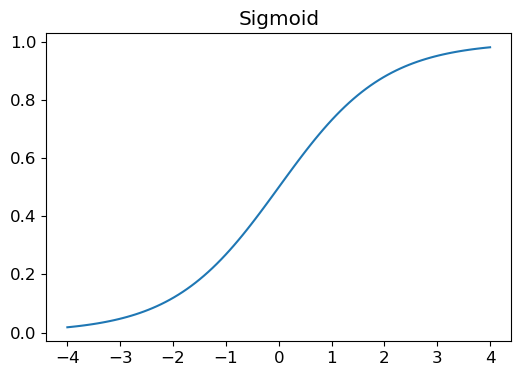

In [278]:
from fastbook import plot_function

plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4) 

It takes any input value, and turns it into an output value between 0 and 1, with a smooth curve that only goes up.
- SGD will have a much easier time with gradients here.

lets redefine `loss_f`

In [279]:
def loss_f(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean() 

## Why do we need a loss again?

We have a metric (overall accuracy) already, why do we need loss?

The **metric** derives *human* understanding.

The *loss* drives *automated learning*

The loss function needs to have a meaningful derivative, and thus, needs to be reasonably smooth.

Our `loss_f` will react to very small changes.

The loss function is calculated for each item in our dataset, and then at the end of an epoch, the loss values are averaged and the overall mean is reported for the epoch.

Metrics, on the other hand, are the numbers **we** care about.
- These are the values printed at the end of the epoch telling us how our model is really doing.
	- We care about this, over the loss when judging the performance of a model.

We now need to consider the details required to update and change the weights based on **gradients**
- This is called an *optimisation* step.

## Gradient (Descent)
To understand gradients, we need to know about derivatives.

### Derivatives
A derivative is used to make machine learning models more efficient, helping to find the fastest path to adjusting model parameters.

A derivative measures how the function's output changes with respect to a change in its input, we can define this for a single-variable function $f(x)$ the derivative with respect to $x$ is denoted as $f'(x)$ or $\frac{df}{dx}$.

The derivative represents the slope of the tangent line to the graph of $f$ at a specific point, giving us more information about the **rate of change of the function**

### Partial Derivatives
Often, a function will have multiple variables.

A partial derivative measures how a function's output changes with respect to a change in **one** specific variable, whilst keeping other variables constant.

For a function $f(x,y)$, the partial derivative with respect to $x$ is $\frac{\delta f}{\delta x}$ and tells us how $f$ changes concerning $x$ while holding $y$ constant.

### Gradient
In machine learning, we often need to optimise a loss function to find the best parameters for our model.

The gradient of a function is simply a vector of its partial derivatives with respect to each input variable.

For a function $f(x_1,x_2,...,x_n)$ its gradient is denoted as $\Delta f$ and is a vector containing the partial derivatives:

$$\Delta f = \left(\frac{\delta f}{\delta x_1},\frac{\delta f}{\delta x_2}...\frac{\delta f}{\delta x_n} \right)$$

 ### Gradient Descent
 Gradient descent is an optimisation algorithm used to minimise a loss function.
 
It works by iteratively adjusting the model parameters in the direction opposite to the gradient of the loss function.

This helps us move towards the mininmum of the loss function, where the model performs the best, it can be define as:

$$New \: parameter \: value = \: Old \: parameter \: value \: - \alpha \Delta f$$

Where $\alpha$ is the learning rate, a hyper-parameter.

### Backpropagation
In neural networks, backpropagation is used to compute gradients of the loss with respect to the models parameters.

It applies the chain rule from derivatives to calculate how the loss changes concerning each parameter in the neural network.

This information is then used to update the model's weights and biases during training.


With that recap out the way, in order to take an optimisation step we need to calculate the loss over one or more data items.
- We could calculate the entire dataset and take an average
- We could just take one item

We will do neither
- Calculating for the whole dataset will take a long time
- Calculating for a single item will not give us any valuable insights.

We will take a middle ground, and take the average loss for a **few data items at a time**
- This is called a mini-batch

Thus, we actually update the model parameters **once per batch** and not once per **epoch**
- Say we have a dataset with 2000 items, and a batch size of 100, in one epoch we could expect to update the parameters 20 times.

The amount of items in a mini-batch is the **batch-size**

A larger batch size means more accurate and stable estimates of the dataset's gradients.
- But it will take longer, and process fewer mini-batches per epoch.

Thus, choosing a good batch size is important.

Machine learning (ideally) makes use of a GPU.
- GPU's are only useful if they have a lot of work to do at a time.
- So it its a good idea to give them lots of data items to work on.

Mini batches are a great way to do this.

Furthermore, we should *vary* the items we put into each mini-batch during training.
- This is because we can get better generalisation in the model if we vary things during training
   - This is a vary easy way to vary things.

Making mini-batches can be done very easily using `PyTorch's` `DataLoader`

A DataLoader takes in any Python collection and turns it into an iterator over mini-batches.

Lets make an example mini-batch of the numbers 0 through 14

In [280]:
coll = range(15)
dl = DataLoader(coll,batch_size=5,shuffle=True)
list(dl)

[tensor([13,  7, 14,  2, 11]),
 tensor([3, 1, 8, 4, 0]),
 tensor([ 6,  9, 10, 12,  5])]

When training a model we need a collection containing independent and dependent variables. ( The inputs and outputs of a model).

A collection that contains tuples of independent and dependent variables is known in PyTorch as a `DataSet`.

Lets create an example, where we map each letter to it's index in the alphabet

In [281]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

When we pass `ds` to a DataLoader, we will get back mini-batches, which themselves are tuples of tensors representing batches of dependent and independent variables.

In [282]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl) 

[(tensor([14, 10, 12, 16,  0, 22]), ('o', 'k', 'm', 'q', 'a', 'w')),
 (tensor([ 6,  3,  9, 25, 18, 23]), ('g', 'd', 'j', 'z', 's', 'x')),
 (tensor([ 2, 24, 20,  8,  1, 13]), ('c', 'y', 'u', 'i', 'b', 'n')),
 (tensor([21, 17,  5,  7,  4, 19]), ('v', 'r', 'f', 'h', 'e', 't')),
 (tensor([11, 15]), ('l', 'p'))]

We now have all the information required to train a model.

We can define `init_params`, as earlier.

In [283]:
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_() 

We can also define our weights and bias, as earlier

In [284]:
weights = init_params((192*192)*3,1)
bias = init_params(1)

We now have a tensor of random values, ready to be used as trainable parameters.

Lets create a dataloader four our data.

Recall that `dset` is our labelled dataset combining train_x and train_y.

In [285]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 110592]), torch.Size([256, 1]))

We've defined our batch size to be 256, rather arbitrarily.
- There will be 256 items in each batch, where each item is a pair $x,y$ 

Our `dset` will be split up into batches of size 256

We need to do the same with our validation dataset, so we judge our data.

In [286]:
valid_dl = DataLoader(valid_dset,batch_size=256)
xbv,ybv = first(valid_dl)
xbv.shape,ybv.shape

(torch.Size([256, 110592]), torch.Size([256, 1]))

Lets just run this by a small batch that we'll create quickly, to see our model in action.

In [287]:
batch = train_x[:4]
batch.shape

torch.Size([4, 110592])

We'll take 4 items from our `train_x` and run some predictions on the data.

In [288]:
preds = linear1(batch)
preds

tensor([0.8155, 1.0090, 1.0767, 0.9474], grad_fn=<AddBackward0>)

But this means nothing to us - lets calculate loss

In [289]:
loss = loss_f(preds,train_y[:4])
loss

tensor(0.3884, grad_fn=<MeanBackward0>)

Lets now calculate the gradients.

In [290]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([110592]), tensor(-0.0002), tensor([-0.0999]))

- loss.backward() calculates gradients of the loss with respect to the models parameters, to gie us an idea of how much each parameter needs to be adjusted to minimise loss.
- `weights.grad.shape` will tell us the shape of the gradients of the weights, it should match our weight tensors.
- `weights.grad.mean()` computes the mean of the gradients of the weights, giving us an insight into the magnitue of parameter updates being calculated.
- `bias.grad` gives us the gradients of the bias term.

We can put the above prediction, loss calculation and gradient calculation into a function.

In [291]:
def calc_grad(xb,yb,model):
    preds = model(xb)
    loss = loss_f(preds,yb)
    loss.backward()

And we can then run it with our 4-size batch from earlier

In [292]:
calc_grad(batch,train_y[:4],linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0003), tensor([-0.1998]))

And call it again...

In [293]:
calc_grad(batch,train_y[:4],linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0005), tensor([-0.2997]))

The gradients are changing.
- loss.backward adds the gradients of the loss to any gradients currently stored.

We need to make sure we **zero out gradients before each backward pass to prevent their acummulation**
- This will ensure gradient updates during training are based solely on the gradients computed for the current batch, and not influenced by past batches.

In [294]:
weights.grad.zero_()
bias.grad.zero_(); 

The only thing left to do is actually update the weights and biases, based on the calculating gradient and learning rate.

We'll tell PyTorch **not** to take the gradient of this step, to not throw off our gradients.
- if we assign a value to the `data` attribute of a tensor, PyTorch will not take the gradient of that step.

We can define the following function

In [313]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            print(p.data)
            p.data -= p.grad*lr
            p.grad.zero_() 

The parameters are:
- model (the ML model function, `linear1`)
- LR - Learning rate
- Params - Our weights and biases, initially randomised.

`for xb,yb` in `dl` iterates our `dataloader`
- In each iteration, `xb` represents a batch of input data, `yb` the corresponding labels.

`calc_grad` is our function from earlier to predict, calculate loss, and calculate derivatives.

We then iterate each parameter, updating each parameter using gradient descent, subtracting the product of the parameter's gradient `p.grad` and the learning rate `lr` form the parameters `data`.
- We are adjusting the models parameters to move them in the direction that reduces loss

`p.data` allows access to the values of a pytorch tensor `p` and manipulate the values of the tensor without tracking these values for `autograd` - which computes gradients.

`p.grad.zero()` zeroes out the gradients again, to prepare for the next batch.

We next need to define a function for our validation accuracy.

Recall each prediction by the model can be between 0 and 1, anything higher than 0.5 leans towards the prediction being a dog and vice versa.

Using this logic, we can define a function:


In [296]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean() 

Lets now test if it works as expected.

Recall earlier we defined batch as the first four values in `train_x`.

In [297]:
batch

tensor([[0.0001, 0.0001, 0.0001,  ..., 0.0011, 0.0010, 0.0011],
        [0.0003, 0.0004, 0.0004,  ..., 0.0026, 0.0026, 0.0025],
        [0.0025, 0.0025, 0.0025,  ..., 0.0010, 0.0010, 0.0009],
        [0.0015, 0.0016, 0.0015,  ..., 0.0007, 0.0006, 0.0006]])

In [298]:
batch_accuracy(linear1(batch),train_y[:4])

tensor(0.7500)

We can conclude 75% accuracy for these first four items.

## Validation set

Recall earlier we made a validation `dl` earlier

Lets define a function to evaluate the accuracy of our model on this validation dataset.

In [299]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

We take in model as a parameter

We iterate through our `valid_dl` DataLoader.
 - Recall the `valid_dl` contains the image tensors `x` and the correct labels `y`, bundled into mini-batches

- We take `xb` and `yb`, the respective `x` prediction and `y` correct values for each item in the dataloader.
- We calculate the accuracy for each batch by calling `batch_accuracy` 
   - Recall `batch_accuracy` is taking in our predictions and labels and returning the mean number of correct guesses.
- the result of this is a list of mean accuracies, one for each batch in the validation dataset.

We will use `torch.stack(accs)` to stack all our accuracies into one single tensor, find the mean of these tensors and round them to 4 decimal places.

Thus, ultimately, we have one final number representing the accuracy of our dataset.

In [300]:
validate_epoch(linear1)

0.6792

Quite nice for a start point, lets train for 1 epoch and see if we improve

In [314]:
lr = 1.
params = weights,bias
train_epoch(linear1,lr,params)
validate_epoch(linear1)

tensor([-0.6629,  1.2453, -0.4638,  ...,  1.6100, -1.4284, -0.8734]) tensor([-0.6629,  1.2453, -0.4638,  ...,  1.6100, -1.4284, -0.8734])
tensor([33.7131]) tensor([33.7131])
tensor([-0.6629,  1.2453, -0.4638,  ...,  1.6100, -1.4284, -0.8734]) tensor([-0.6629,  1.2453, -0.4638,  ...,  1.6100, -1.4284, -0.8734])
tensor([33.7131]) tensor([33.7131])
tensor([-0.6629,  1.2453, -0.4638,  ...,  1.6100, -1.4284, -0.8734]) tensor([-0.6629,  1.2453, -0.4638,  ...,  1.6100, -1.4284, -0.8734])
tensor([33.7131]) tensor([33.7131])
tensor([-0.6629,  1.2453, -0.4638,  ...,  1.6100, -1.4284, -0.8734]) tensor([-0.6629,  1.2453, -0.4638,  ...,  1.6100, -1.4284, -0.8734])
tensor([33.7131]) tensor([33.7131])
tensor([-0.6629,  1.2453, -0.4638,  ...,  1.6100, -1.4284, -0.8734]) tensor([-0.6629,  1.2453, -0.4638,  ...,  1.6100, -1.4284, -0.8734])
tensor([33.7131]) tensor([33.7131])
tensor([-0.6629,  1.2453, -0.4638,  ...,  1.6100, -1.4284, -0.8734]) tensor([-0.6629,  1.2453, -0.4638,  ...,  1.6100, -1.4284, -0

0.6792

In [307]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ') 

0.6792 0.6792 0.6792 0.6792 0.6792 0.6792 0.6792 0.6792 0.6792 0.6792 0.6792 0.6792 0.6792 0.6792 0.6792 0.6792 0.6792 

KeyboardInterrupt: 